## Background

Pump tests are often used in subsurface hydrology to estimate the properties of an aquifer.  The idea is to measure the hydraulic head (i.e., water pressure) in multiple wells as water is extracted from the aquifer.  The change in hydraulic head over time, called the drawdown, provides information about the properties of the aquifer.   In this example, we take a Bayesian view of the classic unsteady pump test and use Bayesian inference to define a probability distribution over the aquifer properties given drawdown observations.

Bayes' rule provides a probabilistic mechanism for updating our "degree-of-belief" about the aquifer properties before and after the pump tesst.   Let $\theta$ denote a vector of parameters describing the aquifer and $d$ denote the pump test observations.  Bayes' rule is then given by

$$
\pi(\theta | d) \propto \pi(d | \theta) \pi(\theta),
$$

where $\pi(\theta)$ is the prior probabity density, which here describes what aquifer properties are likely before seeing any data from the pump test, $\pi(d|\theta)$ is called the likelihood function and measures how likely it is to see the observational data given the parameters, and $\pi(\theta | d)$ is called the posterior probability density.  The posterior represents our knowledge about the parameters after accounting for the prior knowledge in $\pi(\theta)$ and the pump test observations via $\pi(d | \theta)$.

The following sections describe the likelihood and prior for this example in more detail.  The remaining cells will then walk through the definition and solution of this problem with MUQ.


#### Likelihood formulation
The likelihood function $\pi(d | \theta)$ is a statistical model for the observational data that is parameterized by $\theta$.   In Bayesian inverse problems, this statistical model is typically constructed from a physical model of the system (e.g., a model of groundwater flow in the aquifer) and statistical components describing posssible differences between the model output and observational data.   

<img src="drawdown.svg" style="float:right"></img>

Let $\theta^\ast$ denote the "true" aquifer properties and let $s(r,t, \theta^\ast)$ denote the true (as opposed to modeled) drawdown in the aquifer $t$-days after the pumping began and at a distance $r$ from the extraction well.    Now assume that we have observations of the drawdown at locations $r_1,\ldots,r_N$ and times $t_1,\ldots,t_N$.   In practice, these observations will not be perfect and there will be some measurement error between the observation $d_i$ and the *true* drawdown $s_{\text{true}}(r_i,t_i,\theta^\ast)$.  More precisely, there is an error $\epsilon_{\text{obs}}$ defined by

$$
\epsilon_{\text{obs}} = d_i - s_{\text{true}}(r_i,t_i,\theta^\ast).
$$

The true real-world drawdown $s(r_i,t_i,\theta^\ast)$ depends on how water flows through a network of pores in the rock and is a complicated function depending on the microscopic properties of the aquifer.   To model the drawdown mathematically however, we rely on many simplifying assumptions.    In particular, we will assume that the aquifer is confined, homogenous, has constant thickness, and that Darcy's law can be used to relate gradients in hydraulic head to flow.  With these (and a few other) assumptions, Theis (1935)  derived an analytic solution to the flow equation.  It takes the form

$$\begin{equation}
s(r,t, \theta) = \frac{Q}{2\pi T} W\left(\frac{r^2S}{4Tt}\right),
\end{equation}$$

where $\theta=[\log(S), \log(T)]$ contains two parameters $S$ and $T$ called the storativity and the transmissivity, and

$$
W(u)=\int_u^\infty x^{-1} \exp(-x) dx
$$

is called the well function.   For more information on the Theis model, see [Transient Groundwater Flow](https://transientgroundwaterflow.readthedocs.io/en/latest/TransientFlowToAWell.html) by Theo Olsthoorn.   The classic book "Dynamics of Fluids in Porous Media" by Jacob Bear also provides a comprehensive resource on subsurface flow.

**Our goal is to use Bayes' rule to characterize the parameters $\theta=[\log(S), \log(T)]$ from observations of the drawdown $s(r,t)$.** Like the observations, however, the model is not a perfect representation of reality.   We will describe the discrepancy between model and reality through the error $\epsilon_{\text{mod}}$,

$$
\epsilon_{\text{mod}} =  s_{\text{true}}(r,t, \theta) - s(r,t, \theta).
$$

By combining this expression with the observation error above, we obtain

$$
\begin{eqnarray}
d_i &=&  s(r,t, \theta) + \epsilon_{\text{obs}} + \epsilon_{\text{mod}}\\
&=& s(r,t, \theta) + \epsilon
\end{eqnarray}
$$

The likelihood function $\pi(d | \theta)$ in Bayes' rule can be obtained by assuming a particular distribution for the combined error $\epsilon$.  For simplicity, we will make the common assumption that $\epsilon$ is a zero mean Gaussian random variable with diagonal covariance $\sigma^2 I$.  While common, this simple Gaussian form is often not appropriate when more structured observation or modeling error is present.  See [\[Kennedy and O'Hagan 2001\]](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/1467-9868.00294) and [\[Brynjarsdóttir and OʼHagan 2014\]](https://iopscience.iop.org/article/10.1088/0266-5611/30/11/114007/meta) for a deeper discussion on this point.

With $\epsilon\sim N(0,\sigma^2 I)$, the likelihood function is given by:

$$
\begin{eqnarray}
\pi(d | \theta) &=& \prod_{I=1}^N \pi(d_i | \theta)\\
\pi(d_i | \theta) &=& N\left(s(r_i,t_i, \theta),\, \sigma^2\right).
\end{eqnarray}
$$

Note however, that the variance $\sigma^2$ is another unknown parameter in the model.   While it might be possible to estimate the variance of the observation noise $\epsilon_{\text{obs}}$ using repeated observations or detailed knowledge about the sensing system, it is in general more difficult to characterize the modeling error $\epsilon_{\text{mod}}$.   To (partially) overcome this issue, we will include $\sigma^2$ as another parameter--a "hyperparameter"--in our Bayesian inference problem and denote the likelihood function as $\pi(d | \theta, \sigma^2)$.  This is commonly called a hiearchical Bayesian model.


### Prior formulation
To apply Bayes' rule with both the model parameters $\theta$ and noise variance $\sigma^2$, we need to define the joint prior density $\pi(\theta,\sigma^2)$.    We assume that $\sigma^2$ and $\theta$ are independent, so that $\pi(\theta,\sigma^2)=\pi(\theta)\pi(\sigma^2)$.   We will assume that the $S$ and $T$ parameters are lognormal and that the noise variance $\sigma^2$ has an inverse-Gamma distribution.   In particular,

$$
\begin{eqnarray}
\pi(\theta) & = & N\left(\mu, \Sigma \right)\\
\pi(\sigma^2) & = & IG\left(\alpha,\beta\right).
\end{eqnarray}
$$
The values of $\mu$, $\Sigma$, $\alpha$, and $\beta$ are specified in the code below.    The choice of an inverse-Gamma prior  has computational benefits that will be described below when MUQ is used to draw samples of the joint posterior $\pi(\theta, \sigma^2 | d)$.

## Imports

In [1]:
import muq.Modeling as mm
import muq.SamplingAlgorithms as ms
import muq.Utilities as mu
import muq.Approximation as ma

import numpy as np
import h5py

import matplotlib.pyplot as plt
from IPython.display import Image

## Forward Model
Below we implement the drawdown model $s(r,t,\theta)$ as a child of the `muq.Modeling.ModPiece` class.   This class provides an abstract interface that the UQ algorithms in MUQ know how to work with.   Thus, once a model is implemented as a `ModPiece`, it can be used with all of MUQ's forward and inverse UQ capabilities.   As shown below, instances of the `ModPiece` class can also be combined together to define the prior, likelihood, and posterior densities.
 

### `__init__` 
The `__init__` function in this class accepts the predefined positions and times where we want to evaluate the drawdown.   It also accepts a quadrature order for the numerical approximation of $W(u)$ described below.   This function must call the `ModPiece.__init__` function to specify the sizes of all of the inputs and outputs.   Here, the `TheisModel` ModPiece will accept two inputs: one containing the scalar pumping rate and another containing $S$ and $T$.  The `inputSizes` are therefore $[1,2]$.   There is only a single vector-valued output: the drawdown evaluated at the specified radii and times.   The `outputSizes` are simply $[len(radii)]$.


### `WellFunction`
The well function defined above can be estimated using [Gauss-Laguerre quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Laguerre_quadrature) from the `muq.Approximation` module. An $N-$point Gauss-Laguerre quadrature rule creates weights $w_i$ and points $q_i$ such that for any suitable function $f(x)$, 

$$
\int_0^\infty f(x) \exp(-x) dx \approx \sum_{i=1}^N w_i f(q_i).
$$

However, the $x^{-1}$ term in the integrand of the Well function is singular as $u\rightarrow 0$ and the Gauss-Laguerre quadrature rule will not be an accurate approximation.   This can be overcome with two applications of integration by parts, yielding
$$
\begin{eqnarray}
\int_u^\infty x^{-1} \exp(-x) dx & = & -\exp(-u)\log(u) + \int_u^\infty \log(x)\exp(-x) dx\\
& = & -\exp(-u)\log(u) - u(\log(u)-1)\exp(-u) + \int_u^\infty x(\log(x)-1) \exp(-x) dx.
\end{eqnarray}
$$

Thus, the well function can be approximated as 
$$
\begin{eqnarray*}
W(u) & =& -\exp(-u)\log(u) - u(\log(u)-1)\exp(-u) + \int_u^\infty y(\log(y)-1) \exp(-y) dy\\
&\approx &\exp(-u)\left[-\log(u) - u(\log(u)-1) + \sum_{i=1}^N w_i\left[(q_i+u)(\log(q_i+u)-1)\right]\right]
\end{eqnarray*}
$$

The quadrature weights and points $w_i$ and $q_i$ are computed in the `__init__` function of the `TheisModel` class defined below.   MUQ has a `GaussQuadrature` class that can be used with any family of orthogonal polynomials to define the corresponding Gauss quadrature rule.   We create an instance of the Laguerre family with `ma.Laguerre()` and then pass that to the `mm.GaussQuadrature` class.   The points $q_i$ are stored in the `self.qPts` variable and the weights $w_i$ are stored in `self.qWts`.   The `WellFunction` class combines them to estimate the well function as above.


### `EvaluateImpl`
The `EvaluateImpl` function in any child of the `ModPiece` class is used to evaluate a model (or one "piece" of a larger model).   This function provides a way of exposing any model to MUQ.    In the `TheisModel` class defined below, the `EvaluateImpl` function simply calls the Well function and stores the results in the `self.outputs` variable.    

Note that you implement your model in the `EvaluateImpl` function, but you should evaluate your model using the `Evaluate` function, which is defined in the `ModPiece` parent class.   The `Evaluate` function performs additional error checking, timing, and caching that is important in many applications.

In this model, there are two inputs: the pumping rate $Q$, and the aquifer parameters $[S, T]$.  In this function, the first thing we do is extract the values of $Q$, $S$, and $T$ from the list of (potentially) vector-valued inputs passed to this function as `inputs`.     The drawdown is computed at the radii and times specified in the `__init__` function and then saved in the `self.outputs` variable.   **Note that the `EvaluateImpl` function does not return anything.**    

### `JacobianImpl`
Many sampling and optimization algorithms rely on derivative information.  In MUQ, it is possible to expose derivative information for a model through the `GradientImpl`, `JacobianImpl`, `ApplyJacobianImpl`, and `ApplyHessianImpl` functions.   In this example we focus on just the `JacobianImpl` function.   If any of these functions are not implemented, a default implementation using finite differences will be employed.    Implementations of `GradienImpl` and `ApplyJacobianImpl` can be useful when more efficient implementations for the adjoint gradient and tanget linear operator exist for a specific model. 

Assume the vector-valued inputs to a generic `ModPiece` are denoted by as $[x_0,x_1,\ldots, x_M]$ and let $[f_1(x_0,\ldots,x_M), \ldots, f_K(x_0,\ldots,x_M)]$ denote the list of vector-valued outputs for the same `ModPiece`.   The `JacobianImpl` function computes the Jacobian matrix for a single entry in the output list and a single input:

$$
J = \nabla_{x_j} f_i(x)
$$

for given values of $i$ and $j$, which are specified via the `outWrt` and `inWrt` arguments to `JacobianImpl`.



In [2]:
class TheisModel(mm.PyModPiece):
    """
    Solves the Theis equation.
    """

    def __init__(self, radii, times, quadOrder=30):
        super(TheisModel,self).__init__([1,2],[len(radii)])

        # Compute the tensor product of the radii and times
        self.r = radii.ravel()
        self.t = times.ravel()

        # Set up the Gauss-Laguerre quadrature rule for approximating the Theis well function
        poly = ma.Laguerre()
        quad = ma.GaussQuadrature(poly)
        quad.Compute(quadOrder)

        # Save the quadrature points and weights
        self.qPts = quad.Points()
        self.qWts = quad.Weights()

    def WellFunction(self, u, returnDeriv=False):
        """
        $$
        W(u) = \int_u^\infty \frac{\exp(-y)}{y} dy = \int_0^\infty \frac{\exp(-u)}{x+u} \exp(-x) dx
        $$
        """
        
        uall = np.tile(u.reshape(1,-1),(self.qPts.shape[1],1))
        qall = np.tile(self.qPts.reshape(-1,1),(1,u.shape[0]))

        # Compute the well function for all of the values of u
        vals = -np.exp(-u)*np.log(u) - u*(np.log(u)-1)*np.exp(-u)                       \
             + (self.qWts.reshape(1,-1)@(np.exp(-uall)*(qall+uall)*(np.log(uall+qall)-1))).ravel()
        
        if(returnDeriv==True):
            
            # Compute dW/du for all the values of u
            derivs  = np.exp(-u)*np.log(u) -np.exp(-u)/u - (np.log(u)-1)*np.exp(-u) - np.exp(-u) + u*np.exp(-u)*(np.log(u)-1)
            temp = np.exp(-uall)*(np.log(qall+uall)-1) + (qall+uall)*(np.exp(-uall)/(qall+uall) - np.exp(-uall)*(np.log(uall+qall)-1))
            derivs += (self.qWts.reshape(1,-1)@temp).ravel()
            
            return vals, derivs
        
        else:
            return vals

    def EvaluateImpl(self, inputs):
        """
        $$
        s = \frac{Q}{4\pi T} W\left(\frac{r^2 S}{4Tt})
        $$
        """
        
        Q = inputs[0][0]
        S = inputs[1][0]
        T = inputs[1][1]

        u = self.r*self.r * S / (4.0*T*self.t)
        wu = self.WellFunction(u)
        self.outputs = [ (Q/(4.0*np.pi*T)) * wu ]
        
        
    def JacobianImpl(self, outWrt, inWrt, inputs):
        """
        
        """
        
        Q = inputs[0][0]
        S = inputs[1][0]
        T = inputs[1][1]

        u = self.r*self.r * S / (4.0*T*self.t)
        wu, dw_du = self.WellFunction(u,returnDeriv=True)
        
        if(inWrt==0):
            """ Compute the derivative wrt Q """
            ds_dQ = (1.0/(4*np.pi*T))*wu
            self.jacobian = ds_dQ.reshape(-1,1)
            
        else:
            """ Compute derivatives wrt S and T """
            du_dS = self.r*self.r/(4.0*T*self.t)
            ds_dS = (Q/(4*np.pi*T)) * dw_du * du_dS 
            
            du_dT = self.r*self.r*S/(4.0*T*T*self.t)
            ds_dT = -(Q/(4*np.pi*T*T))*wu - (Q/(4*np.pi*T))*dw_du*du_dT
            
            self.jacobian = np.hstack([ ds_dS.reshape(-1,1), ds_dT.reshape(-1,1)])
            

## Model Evaluation
Just to check that everything seems to be working, here we evaluate the `TheisModel` for specific pumping rate and aquifer properties.

In [3]:
rs = np.array([350]) # Distance in meters from pump
ts = np.array([1.0])

theis = TheisModel(rs, ts)

Q = 2400  # Pumping rate in [m^3/d]
S = 0.001 # Storativity [unitless]
T = 2400  # Aquifer transmissivity [m^2/d]


inputs = [[Q],[S,T]]
outputs = theis.Evaluate(inputs)

print('Predicted drawdown\n s(r=%0.0f, t=%0.0f) = %0.5f\n'%(rs[0],ts[0],outputs[0][0]))

Predicted drawdown
 s(r=350, t=1) = 0.30214



## Jacobian Test
After implementing a new model, it is often useful to make sure that the Jacobian implementation is correct.  Here we leverage finite difference approximations, via the `JacobianByFD` function, to make sure the `JacobianImpl` function is correct.

In [4]:
jac1 = theis.Jacobian(0,0,inputs)
jac1_fd = theis.JacobianByFD(0,0,inputs)

jac2 = theis.Jacobian(0,1,inputs)
jac2_fd = theis.JacobianByFD(0,1,inputs)

absErr = (jac1[0,0]-jac1_fd[0,0])
relErr = absErr / np.abs(jac1_fd[0,0])
print('Error in Jacobian wrt Q\n (Abs., Rel.) = (%8.1e, %8.1e)\n'%(absErr,relErr))

absErr = (jac2[0,0]-jac2_fd[0,0])
relErr = absErr / np.abs(jac2_fd[0,0])
print('Error in Jacobian wrt S\n (Abs., Rel.) = (%8.1e, %8.1e)\n'%(absErr,relErr))


absErr = (jac2[0,1]-jac2_fd[0,1])
relErr = absErr / np.abs(jac2_fd[0,1])
print('Error in Jacobian wrt T\n (Abs., Rel.) = (%8.1e, %8.1e)\n'%(absErr,relErr))

Error in Jacobian wrt Q
 (Abs., Rel.) = (-1.0e-10, -7.9e-07)

Error in Jacobian wrt S
 (Abs., Rel.) = (-4.0e-04, -5.1e-06)

Error in Jacobian wrt T
 (Abs., Rel.) = ( 3.4e-10,  3.6e-06)



# The Data

The cell below contains data from a real pump test in the Netherlands at "Oude Korendijk."   We have adapted the data from the [Transient Groundwater Flow](https://transientgroundwaterflow.readthedocs.io/en/latest/TheisWellFunction.html#The-data:) documentation, which is based on the  book [Analysis and Evaluation of Pumping Test Data](https://www.hydrology.nl/images/docs/dutch/key/Kruseman_and_De_Ridder_2000.pdf) by Kruseman and De Ridder.

In this test, there are three wells at 30, 90, and 215 meters away from the pumping well.

In [5]:
#       t[min],  s[m]
H30 = np.array([[0.1, 0.04],
                [0.25, 0.08],
                [0.50, 0.13],
                [0.70, 0.18],
                [1.00, 0.23],
                [1.40, 0.28],
                [1.90, 0.33],
                [2.33, 0.36],
                [2.80, 0.39],
                [3.36, 0.42],
                [4.00, 0.45],
                [5.35, 0.50],
                [6.80, 0.54],
                [8.30, 0.57],
                [8.70, 0.58],
                [10.0, 0.60],
                [13.1, 0.64]])


#    t[min],  s[m]
H90 = np.array([[1.5, 0.015],
                [2.0, 0.021],
                [2.16, 0.023],
                [2.66, 0.044],
                [3.00, 0.054],
                [3.50, 0.075],
                [4.00, 0.090],
                [4.33, 0.104],
                [5.50, 0.133],
                [6.0, 0.154],
                [7.5, 0.178],
                [9.0, 0.206],
                [13.0, 0.250],
                [15.0, 0.275],
                [18.0, 0.305],
                [25.0, 0.348],
                [30.0, 0.364]])

#       t[min],  s[m]
H215 = np.array([[66.0, 0.089],
                [127., 0.138],
                [185., 0.165],
                [251., 0.186]])

To use this data with the model below, we will need to combine each of the arrays into a single matrix with an additional column for the radius.

In [6]:
H = np.hstack([30*np.ones((H30.shape[0],1)), H30])
H = np.vstack([H, np.hstack([90*np.ones((H90.shape[0],1)), H90])])
H = np.vstack([H, np.hstack([215*np.ones((H215.shape[0],1)), H215])])

# Convert the data times to have units of days
H[:,1] /= (24*60)

# Inverse Problem Setup

We now have a model and data.  The follow cells leverage these ingredients to create a graph of `ModPiece` instances that evaluate the posterior density.   Note that the pumping rate is fixed to a known value and the only unknown inputs to the posterior graph are $\theta=[\log(S),\log(T)]$ and $\sigma^2$.

#### Forward Model
- Create an instance of the `TheisModel` class that will predict drawdowns at our observation locations and times.
- Connect model components on a `WorkGraph` to define a mapping from $\theta\rightarrow s(r,t,\theta)$. 

In [7]:
theisMod = TheisModel(H[:,0], H[:,1])

graph = mm.WorkGraph()

# Add the forward model
graph.AddNode(theisMod, 'Theis')

# Add a fixed pumping rate
pumpRate = mm.ConstantVector(Q*np.ones(1))
graph.AddNode(pumpRate, 'PumpRate')
graph.AddEdge('PumpRate',0,'Theis',0)

# Add an exponential transformation of the log parameters
graph.AddNode(mm.IdentityOperator(2), 'Log Parameters')
graph.AddNode(mm.ExpOperator(2), 'Parameters')
graph.AddEdge('Log Parameters', 0, 'Parameters', 0)
graph.AddEdge('Parameters', 0, 'Theis', 1)

The `graph.Visualize` function allows us to see what the graph of model components looks like so far:

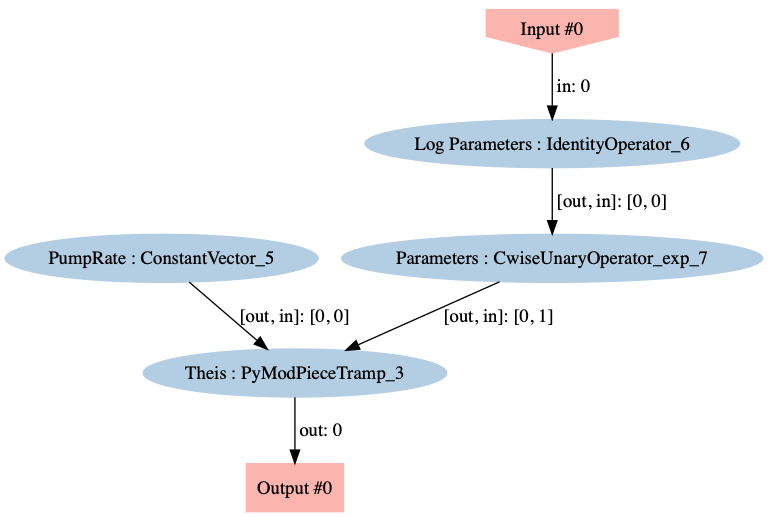

In [8]:
graph.Visualize('PosteriorGraph_Step1.png')
Image('PosteriorGraph_Step1.png')

#### Prior Density
Here we define the lognormal prior distribution on $[S,T]$ by  setting the mean and variance of $\theta=[\log(S),\log(T)]$.   To compute the mean and variance, we set the 5% and 95% quantiles for $[S,T]$ and then leverage the log of these quantiles are approximately $\mu_\theta\pm 2\sigma_\theta$, where $\mu_\theta$ is the mean of $\theta$ and $\sigma_\theta$ is standard deviation of $\theta$.

Once the mean and variance are defined, a Gaussian `ModPiece` is created and added to the graph of model components.

In [9]:
qs05 = np.array([1e-5, 1e1]) # 5% quantile for Storativity parameter S and transmissivity T
qs95 = np.array([1e-2, 1e5]) # 95% quantile for Storativity parameter S and transmissivity T

priorMean = 0.5*(np.log(qs95)+np.log(qs05))
priorStd = 0.5*(np.log(qs95)-priorMean) # Assumes 95% quantile is 2 standard deviations away

priorVar = priorStd**2

priorDist = mm.Gaussian(priorMean, priorVar)


graph.AddNode(priorDist.AsDensity(), "Prior")
graph.AddEdge('Log Parameters',0, 'Prior', 0)

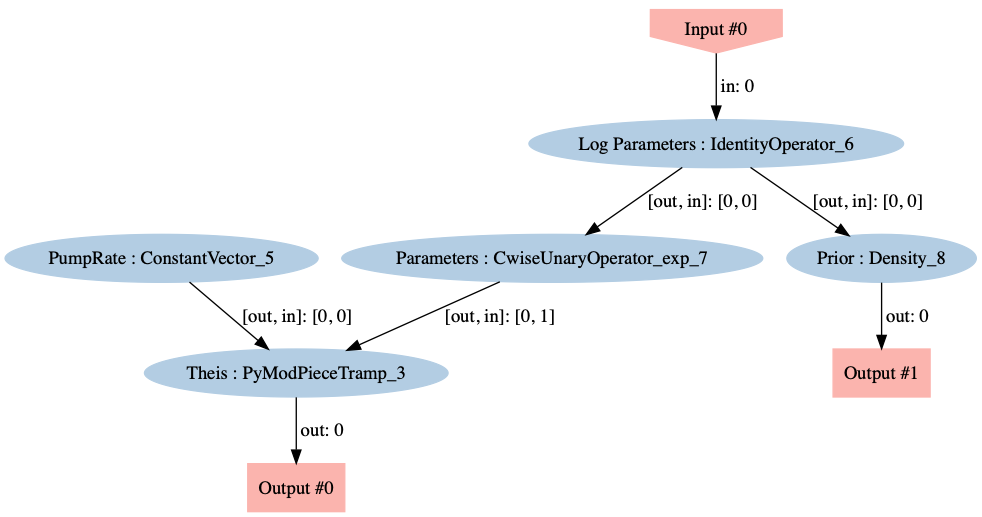

In [10]:
graph.Visualize('PosteriorGraph_Step2.png')
Image('PosteriorGraph_Step2.png')

#### Likelihood Function
Here we define the Gaussian likelihood function.  It is constructed from a Gaussian density with mean given by the observations.   The additional `mm.Gaussian.DiagCovariance` argument specifies that the Gaussian will also requrie an input with a vector containing the variance.   The variance passed to the `Gaussian` class is the same size as the data -- one variance for each observaton.   In this example however, the variance is constant across all locations and times.  To account for this, we include another ModPiece, the `DenseLinearOperator` piece with a single column vector of ones.  This column vector will map the constant variance to the vector required by the `Gaussian` class.

In [11]:
graph.AddNode(mm.IdentityOperator(1), 'Noise Variance')
graph.AddNode(mm.DenseLinearOperator(np.ones(H.shape[0])), 'Variance Vector')
graph.AddEdge('Noise Variance', 0, 'Variance Vector', 0)

likely = mm.Gaussian(H[:,2], mm.Gaussian.DiagCovariance)

graph.AddNode(likely.AsDensity(), "Likelihood")
graph.AddEdge('Theis', 0, 'Likelihood', 0)
graph.AddEdge('Variance Vector', 0, 'Likelihood', 1)

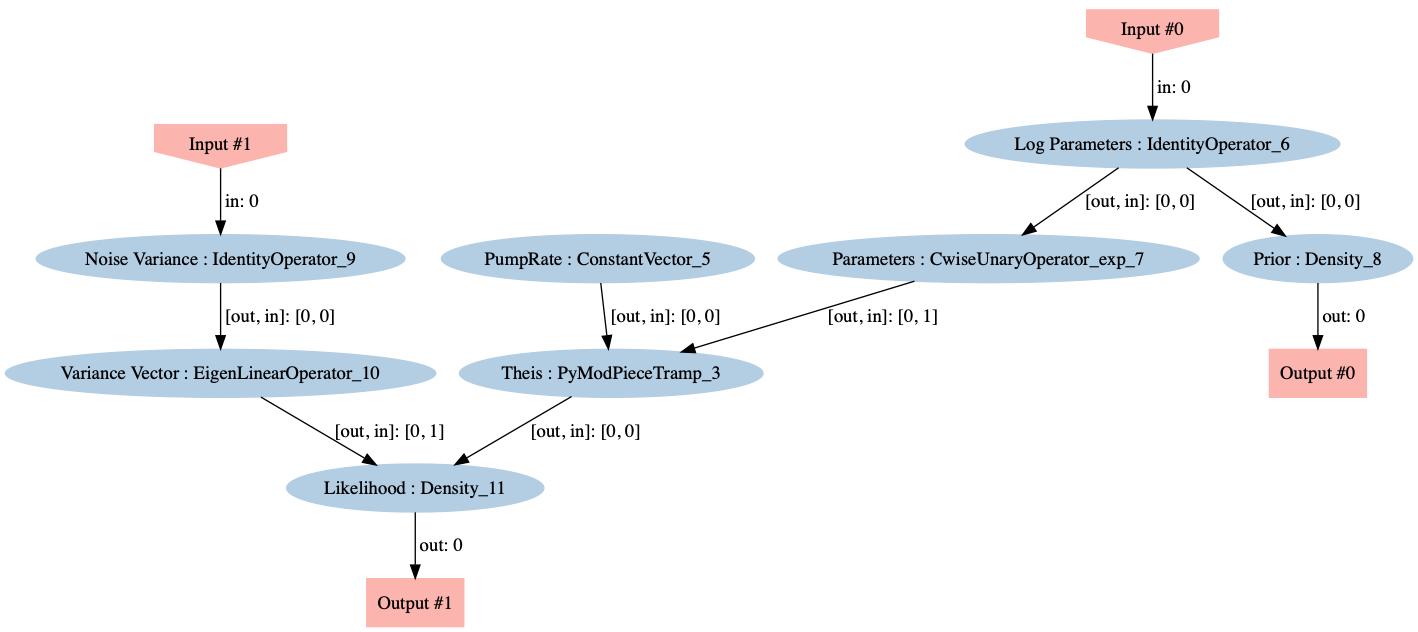

In [12]:
graph.Visualize('PosteriorGraph_Step3.png')
Image('PosteriorGraph_Step3.png')

#### Hyperprior $\pi(\sigma^2)$

We need to specify a prior $\pi(\sigma^2)$ on the noise variance $\sigma^2$.  Here we use an [inverse-Gamma distribution](https://en.wikipedia.org/wiki/Inverse-gamma_distribution) for $\pi(\sigma^2)$, which is a common choice because the inverse-Gamma distribution is a [conjugate distribution for a Gaussian likelihood](https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf) with unknown variance.  As shown below, MUQ can also leverage this conjugacy to accelerate MCMC sampling.

In [13]:
# Define the hyperprior, the mean is given by beta/(alpha-1)
alpha = 1.001
beta = 5e-3
varDens = mm.InverseGamma(alpha,beta)

graph.AddNode(varDens.AsDensity(), 'HyperPrior')
graph.AddEdge('Noise Variance', 0, 'HyperPrior', 0)

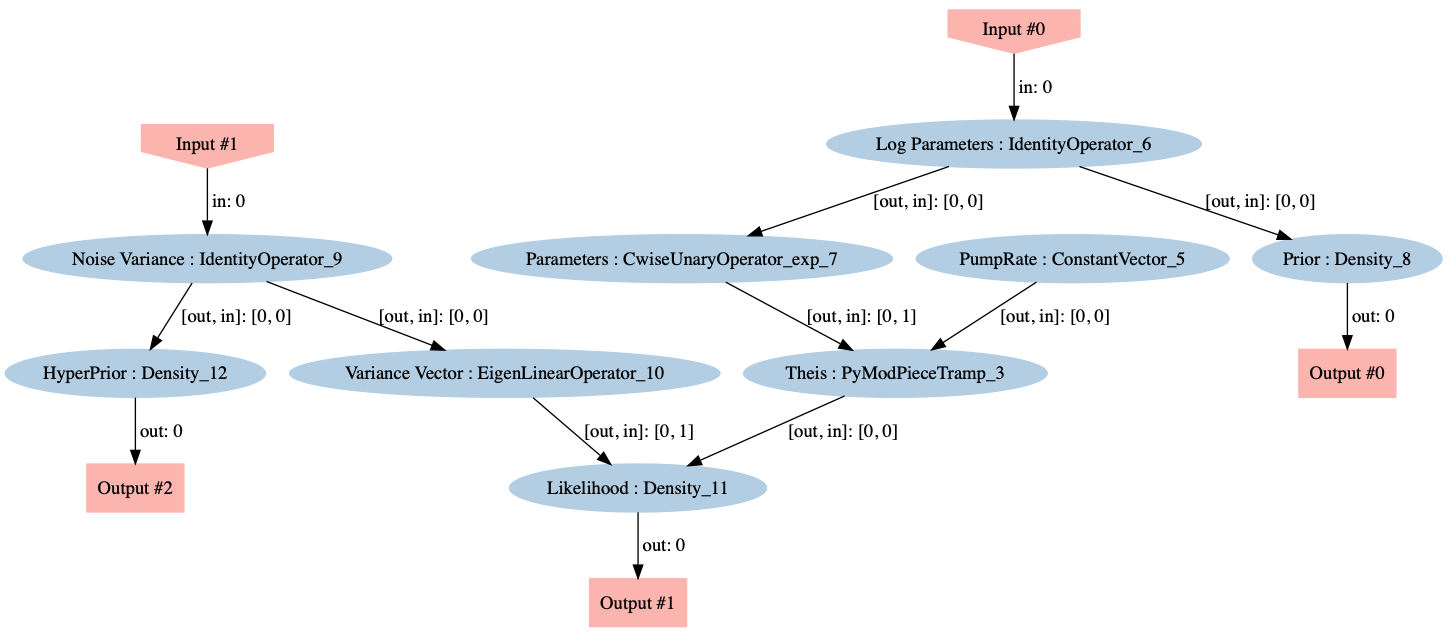

In [14]:
graph.Visualize('PosteriorGraph_Step4.png')
Image('PosteriorGraph_Step4.png')

#### Plot the Hyperprior

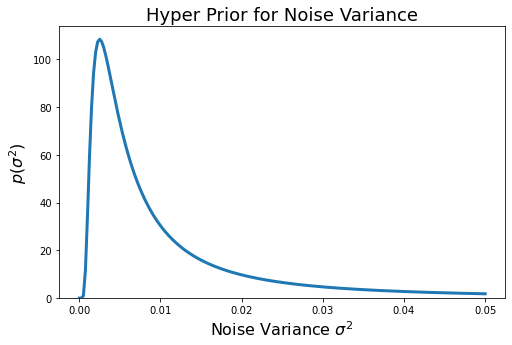

In [15]:
sigmas = np.linspace(1e-6,5e-2,200)
logDens = [varDens.LogDensity([s]) for s in sigmas]

plt.figure(figsize=(8,5))
plt.plot(sigmas,np.exp(logDens),linewidth=3)
plt.xlabel('Noise Variance $\sigma^2$', fontsize=16)
plt.ylabel('$p(\sigma^2)$', fontsize=16)
plt.title('Hyper Prior for Noise Variance', fontsize=18)

ymin,ymax = plt.ylim()
plt.ylim(0,ymax)
plt.show()

#### Posterior
We have now defined all of the ingredients in our posterior density and simply need to define the posterior via the product 

$$
\pi(\theta,\sigma^2 | d) \propto \pi(d|\theta,\sigma^2)\pi(\theta)\pi(\sigma^2).
$$

This cell uses the `DensityProduct` class to accomplish this.

In [16]:
graph.AddNode(mm.DensityProduct(3),'Posterior')

graph.AddEdge('Likelihood',0,'Posterior',0)
graph.AddEdge('Prior', 0, 'Posterior', 1)
graph.AddEdge('HyperPrior', 0, 'Posterior', 2)

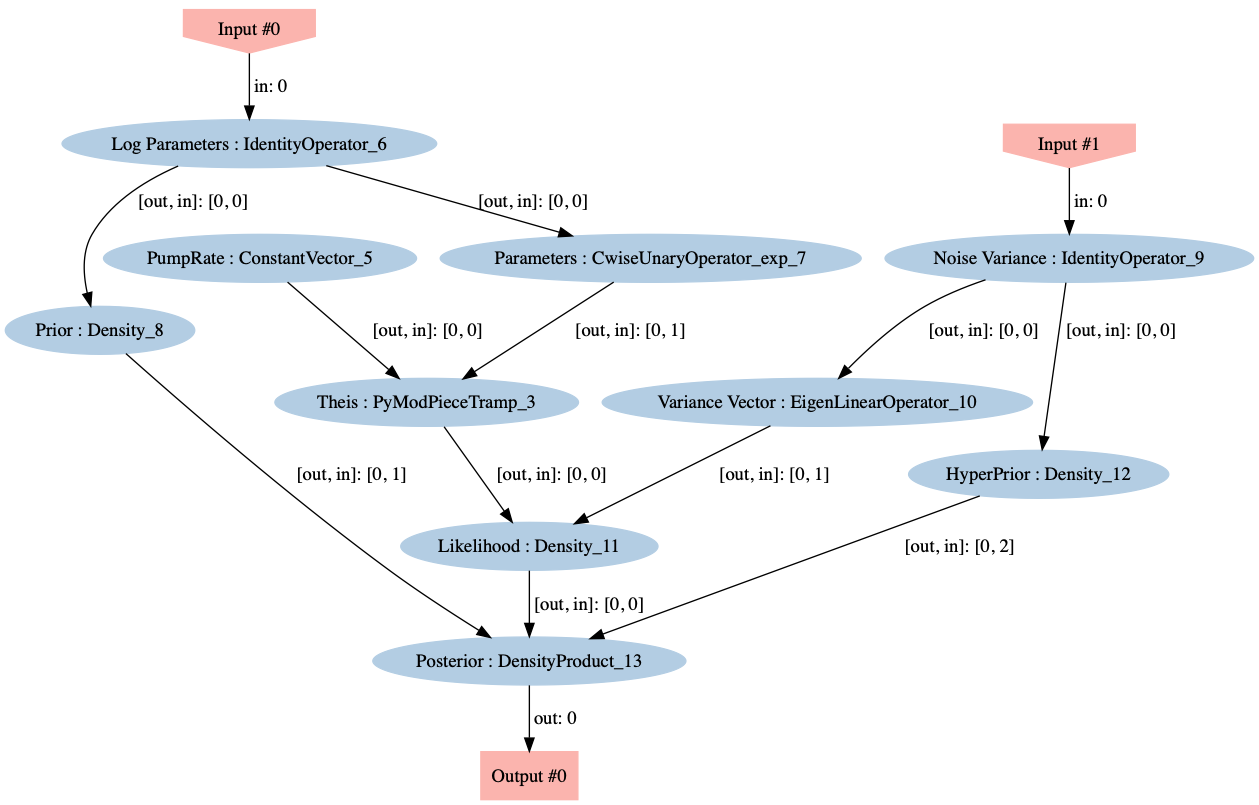

In [17]:
graph.Visualize('InverseProblemGraph.png')
Image(filename='InverseProblemGraph.png') 

## MCMC Sampling Background
The previous cells have defined a graphical model for evaluating the posterior density.   Now our goal is to use this density to draw samples from the posterior distribution using Markov chain Monte Carlo (MCMC).  The samples could then be used for computing posterior expectations and characterizing predictive distributions. 

The idea behind MCMC is to construct a Markov chain such that the states in the chain can be used (asymptotically at least) as samples from the posterior density $\pi(\theta,\sigma^2 | d)$.   The Markov chain is constructed from a Markov transition kernel $T(\cdot; \theta_k,\sigma^2_k)$, which is a distribution over the next state $(\theta_{k+1},\sigma^2_{k+1})$ in the chain given the current state $(\theta_k,\sigma^2_k)$.   See one of the many excellent books on MCMC, like ["Markov Chain Monte Carlo in Practice"](https://www.amazon.com/Markov-Practice-Chapman-Interdisciplinary-Statistics/dp/0412055511) or ["Handbook of Markov chain Monte Carlo"](https://www.amazon.com/Handbook-Chapman-Handbooks-Statistical-Methods/dp/1420079417) for more For more information on the many different flavors of MCMC algorithms.


Without going into the details, it is important to point out that not all of the parameters need to be updated in every MCMC step.  Approaches, such as Gibbs and Metropolis-in-Gibbs sampling, work by defining a sequence of transition kernels that each update a single block of the parameters.  In this example, we will consider two transition kernels, one that takes a step in $\theta$ using the Metropolis-Hastings rule with the target density $\pi(\theta | d, \sigma^2_k)$ and one that takes a step in $\sigma^2$ using the target density $\pi(\sigma^2_k | d, \theta)$.   Splitting the transition kernel in this way allows us to exploit the inverse-Gamma prior on $\sigma^2$ and directly draw a sample of the conditional distribution $\pi(\sigma^2_k | d, \theta)$.   On the other hand, it is not directly possible to directly sample $\pi(\theta | d, \sigma^2_k)$ because it depends on the nonlinear Theis model.   The update of the model parameters $\theta$ will therefore rely on the [Metropolis-Hastings rule](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).


## MCMC In MUQ
To use the MCMC algorithms in MUQ, we first need to define a `SamplingProblem`.  Here we create a `ModPiece` from the graph defined above and use that to define a basic sampling problem.   More sophisticated sampling problems might require more information, such as a hierarchy of models with different fidelities.

In [18]:
post = graph.CreateModPiece("Posterior")
prob = ms.SamplingProblem(post)

#### Parameter Kernel
Define the Metropolis-Hastings transition kernel on the $\theta$ block.  Here, we build the transition kernel from a Metropolis-Adjusted Langevin (MALA) proposal, which uses the gradient of the log posterior (and thus the Jacobian of the `TheisModel`) to "shift" the proposal towards regions of high density.

In [19]:
opts = dict()
opts['StepSize'] = 0.005 # Stepsize for MALA proposal

paramProp = ms.MALAProposal(opts, prob)
paramKernel = ms.MHKernel(opts, prob, paramProp)
paramKernel.SetBlockInd(0) # <- The block number corresponds to the "Input #" shown above in the posterior graph

#### Variance Kernel
Createe the kernel on the $\sigma^2$ block.  Here, we use the `InverseGammaProposal` class, which directly samples from $\pi(\sigma^2 | d, \theta)$.   The exact conditional relationship is extracted from the posterior graph, which requires telling the proposal which nodes in the graph correspond to the hyper prior on the variance $\sigma^2$ and the Gaussian density (e.g., "Likelihood) using the variance.

In [20]:
opts['InverseGammaNode'] = 'HyperPrior'
opts['GaussianNode'] = 'Likelihood'

varProp = ms.InverseGammaProposal(opts, prob)
varKernel = ms.MHKernel(opts, prob, varProp)
varKernel.SetBlockInd(1) # <- The block number corresponds to the "Input #" shown above in the posterior graph

#### Running the Chain
The `SingleChainMCMC` class takes a list of kernels and options specifying the length of the chain and how many steps to ignore at the beginning of the chain, i.e., the burn-in.   

The `mcmc.Run` function returns a `SampleCollection` object that can be used for computing posterior moments or assessing the quality of the MCMC chain.  It is also possible to simple convert the `SampleCollection` to a numpy array with the `AsMatrix` function.

In [21]:
opts['NumSamples'] = 20000
opts['BurnIn'] = 50

mcmc = ms.SingleChainMCMC(opts, [paramKernel, varKernel])

var = [beta/(alpha-1)] # Set the starting value of the variance to the hyperprior mean
startPt = [priorMean, var] # Start at the prior mean

samps = mcmc.Run(startPt) # Run the chain
sampMat = samps.AsMatrix() # Extract a numpy array of samples

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      MHKernel acceptance Rate =  63%
    Block 1:
      MHKernel acceptance Rate = 100%
  20% Complete
    Block 0:
      MHKernel acceptance Rate =  60%
    Block 1:
      MHKernel acceptance Rate = 100%
  30% Complete
    Block 0:
      MHKernel acceptance Rate =  60%
    Block 1:
      MHKernel acceptance Rate = 100%
  40% Complete
    Block 0:
      MHKernel acceptance Rate =  60%
    Block 1:
      MHKernel acceptance Rate = 100%
  50% Complete
    Block 0:
      MHKernel acceptance Rate =  60%
    Block 1:
      MHKernel acceptance Rate = 100%
  60% Complete
    Block 0:
      MHKernel acceptance Rate =  61%
    Block 1:
      MHKernel acceptance Rate = 100%
  70% Complete
    Block 0:
      MHKernel acceptance Rate =  61%
    Block 1:
      MHKernel acceptance Rate = 100%
  80% Complete
    Block 0:
      MHKernel acceptance Rate =  61%
    Block 1:
      MHKernel acceptance Rate = 100%
  90% Complete
    Block 0

In [22]:
ess = samps.ESS()
print('Effective Sample Size: ', ess)

Effective Sample Size:  [ 510.40914535  558.3618987  7711.28596105]


## Visualize the Posterior

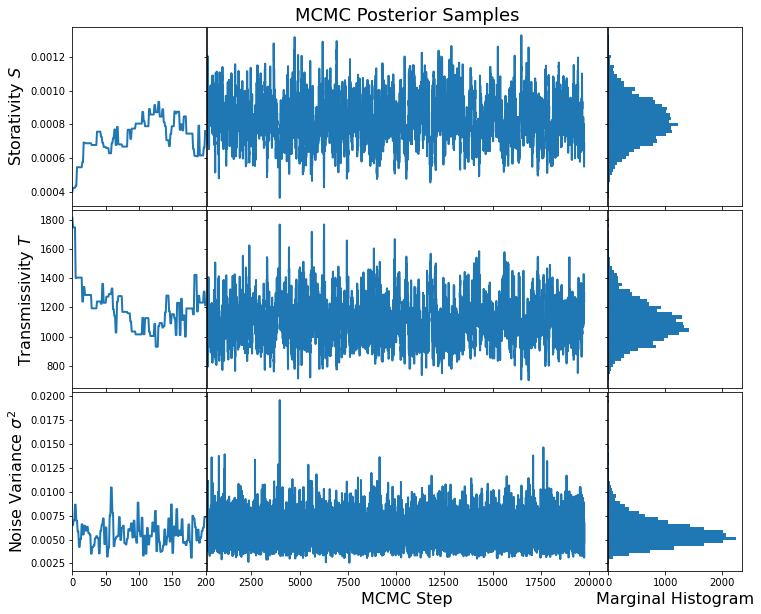

In [23]:
fig, axs = plt.subplots(nrows=3,ncols=3, sharey='row', sharex='col', figsize=(12,10), gridspec_kw={'width_ratios': [1,3, 1]})

zoomInd = 200
axs[0,0].plot(np.exp(sampMat[0,0:zoomInd]),linewidth=2)
axs[0,1].plot(np.exp(sampMat[0,zoomInd:]),linewidth=2)
axs[0,0].set_ylabel('Storativity $S$',fontsize=16)
axs[0,0].set_xlim([0,zoomInd])
axs[0,1].set_xlim([zoomInd, 1.05*sampMat.shape[1]])

axs[1,0].plot(np.exp(sampMat[1,0:zoomInd]),linewidth=2)
axs[1,1].plot(np.exp(sampMat[1,zoomInd:]),linewidth=2)
axs[1,0].set_ylabel('Transmissivity $T$',fontsize=16)

axs[2,0].plot(sampMat[2,0:zoomInd],linewidth=2)
axs[2,1].plot(sampMat[2,zoomInd:],linewidth=2)
axs[2,0].set_ylabel('Noise Variance $\sigma^2$',fontsize=16)
axs[2,1].set_xlabel('MCMC Step',fontsize=16)

axs[0,2].hist(np.exp(sampMat[0,:]), 50, orientation='horizontal')
axs[1,2].hist(np.exp(sampMat[1,:]), 50, orientation='horizontal')
axs[2,2].hist(sampMat[2,:], 50, orientation='horizontal')
axs[2,2].set_xlabel('Marginal Histogram',fontsize=16)

axs[0,1].set_title('MCMC Posterior Samples', fontsize=18)
plt.subplots_adjust(wspace=0.005, hspace=0.02)
plt.show()

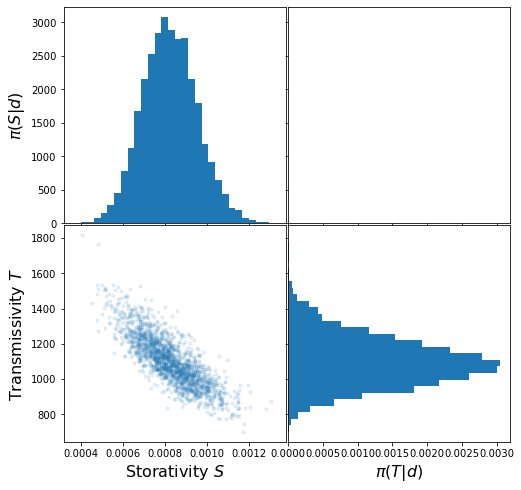

In [24]:
fig, axs = plt.subplots(sharex='col',sharey='row', ncols=2,nrows=2, figsize=(8,8))

axs[0,0].hist(np.exp(sampMat[0,:]),30,density=True)
axs[0,0].set_ylabel('$\pi(S | d)$',fontsize=16)

axs[1,0].plot(np.exp(sampMat[0,::10]), np.exp(sampMat[1,::10]),'.', alpha=0.1)
axs[1,0].set_xlabel('Storativity $S$',fontsize=16)
axs[1,0].set_ylabel('Transmissivity $T$',fontsize=16)


axs[1,1].hist(np.exp(sampMat[1,:]),30, orientation='horizontal', density=True)
axs[1,1].set_xlabel('$\pi(T | d)$',fontsize=16)

plt.subplots_adjust(wspace=0.01,hspace=0.01)

plt.show()

## Posterior Predictive

#### Construct and Evaluate the Predictive Model

In [25]:
numTimes = 100
radii = 90*np.ones(numTimes) # Radius in meters
times = np.linspace(1,50,numTimes)/(24*60) # Time in days

predMod = TheisModel(radii,times)

pred = np.zeros((sampMat.shape[1],numTimes))
predNoisy = np.zeros((sampMat.shape[1],numTimes))

for i in range(sampMat.shape[1]):
    inputs = np.array([ np.exp(sampMat[0,i]), np.exp(sampMat[1,i])])
    
    # Get the Theis model prediction
    pred[i,:] = predMod.Evaluate([[Q], inputs ])[0]
    
    # Add noise
    noiseStd = np.sqrt(sampMat[2:,i])
    predNoisy[i,:] = pred[i,:] + noiseStd*np.random.randn(numTimes)
    

#### Visualize the Posterior Predictive

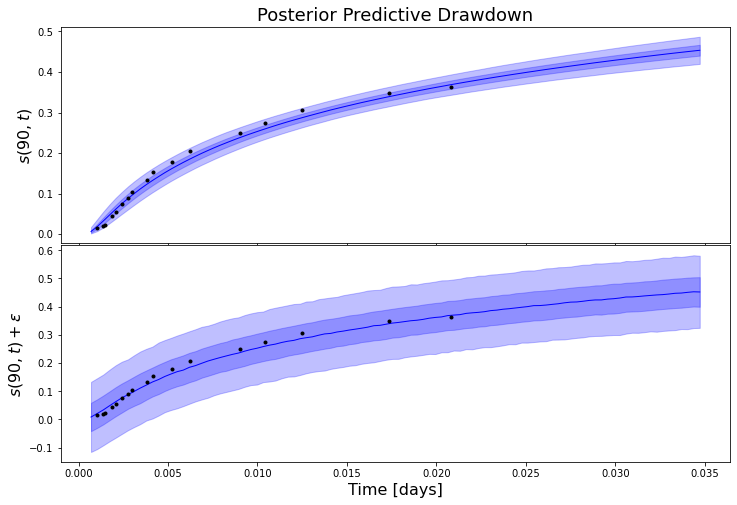

In [26]:
fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(12,8))

qlevels = [5,25,50,75,95]
qs = [np.percentile(pred,q,axis=0) for q in qlevels]
qsNoisy = [np.percentile(predNoisy,q,axis=0) for q in qlevels]


axs[0].fill_between(times, qs[0],qs[-1], color='b', label='%d - %d Quantiles'%(qlevels[0],qlevels[-1]),alpha=0.25)
axs[0].fill_between(times, qs[1],qs[-2], color='b', label='%d - %d Quantiles'%(qlevels[1],qlevels[-2]),alpha=0.25)

axs[0].plot(times, qs[2], 'b', linewidth=1, label="Median")
axs[0].plot(H90[:,0]/(24*60), H90[:,1], '.k', label='Observations')
axs[0].set_ylabel('$s(%d,t)$'%radii[0], fontsize=16)
axs[0].set_title('Posterior Predictive Drawdown',fontsize=18)


axs[1].fill_between(times, qsNoisy[0],qsNoisy[-1], color='b', label='%d - %d Quantiles'%(qlevels[0],qlevels[-1]), alpha=0.25)
axs[1].fill_between(times, qsNoisy[1],qsNoisy[-2], color='b', label='%d - %d Quantiles'%(qlevels[1],qlevels[-2]),alpha=0.25)
axs[1].plot(times, qsNoisy[2], 'b', linewidth=1, label="Median")

axs[1].plot(H90[:,0]/(24*60), H90[:,1], '.k', label='Observations')
axs[1].set_ylabel('$s(%d,t)+\epsilon$'%radii[0], fontsize=16)
axs[1].set_xlabel('Time [days]', fontsize=16)
plt.subplots_adjust(hspace=0.01)